In [1]:
import tensorflow as tf
from scipy.io import loadmat
import random
import math
import tensorflow_probability as tfp

In [2]:
data_location = '/content/drive/MyDrive/mlpapers/GP_Collab_SVHN'

In [3]:
# Run this cell to load the dataset
train = loadmat(f'{data_location}/train_32x32.mat')
test = loadmat(f'{data_location}/test_32x32.mat')
extra = loadmat(f'{data_location}/extra_32x32.mat')

In [4]:
# we have  png files with house numbers for the extra as well, in case of other ideas
# https://stackoverflow.com/questions/15612373/convert-image-png-to-matrix-and-then-to-1d-array


In [5]:
# Set up the imports

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np

import site
import os
import tensorflow as tf
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import errno
import numpy as np
import itertools
import multiprocessing
import json
import datetime
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.summary import create_file_writer

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


In [6]:
print(np.unique(test['y'][:12000])) # just checking that there is no order to the test data
print(train['X'].shape)
print(test['X'].shape)
print(extra['X'].shape)
print(extra['y'].shape)

[ 1  2  3  4  5  6  7  8  9 10]
(32, 32, 3, 73257)
(32, 32, 3, 26032)
(32, 32, 3, 531131)
(531131, 1)


In [7]:
train_data = train['X']
validation_data = test['X']
test_data = extra['X'][:,:,:,:30000]
train_targets = train['y']
validation_targets = test['y']
test_targets = extra['y'][:30000]

In [8]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
            
        ax.imshow(images[:,:,:,i])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images(train_data[:,:,:,idxs],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[7441, 26804, 28122, 47358, 48299, 51842, 53592, 54237, 67493, 69723]


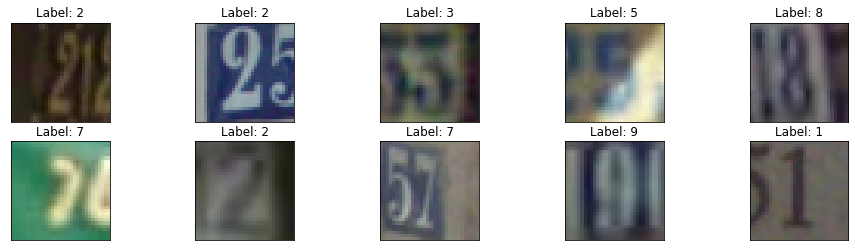

In [9]:
plot_sample(10)

Convert the train, test and validation data to greyscale

In [10]:
train_data_grey = train_data.mean(axis=2)
train_data_grey = np.expand_dims(train_data_grey,axis=2)
train_data_grey = np.moveaxis(train_data_grey, 3, 0)

test_data_grey = test_data.mean(axis=2)
test_data_grey = np.expand_dims(test_data_grey,axis=2)
test_data_grey = np.moveaxis(test_data_grey, 3, 0)

validation_data_grey = validation_data.mean(axis=2)
validation_data_grey = np.expand_dims(validation_data_grey,axis=2)
validation_data_grey = np.moveaxis(validation_data_grey, 3, 0)

print(train_data.shape)
print(train_data_grey.shape)

(32, 32, 3, 73257)
(73257, 32, 32, 1)


Set the 10th class to zero (represents '0' digit)

In [11]:
train_targets[train_targets == 10] = 0
validation_targets[validation_targets == 10] = 0
test_targets[test_targets == 10] = 0

In [12]:
def plot_images_grey(images, nrows, ncols, cls_true):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
        ax.imshow(images[i,:,:,0],cmap='gray', vmin=0, vmax=255)
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample_grey(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images_grey(train_data_grey[idxs,:,:,:],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[2590, 3185, 11955, 34488, 35645, 44746, 61495, 64575, 68096, 68665]


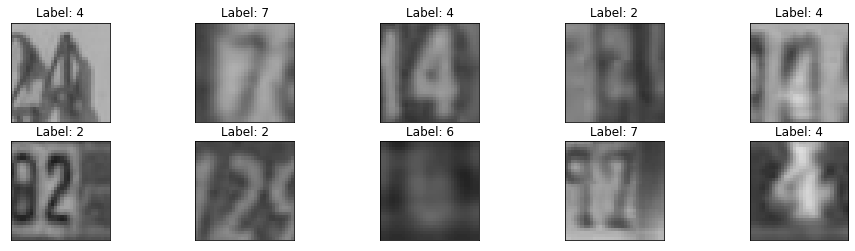

In [13]:
plot_sample_grey(10)

In [14]:
# extracts the layer from a model using the name
def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')


In [23]:
paper_name = "gpSVHN"
acceptable_string_grabs = [ "CNN_A_", "DNN_A_"]
# model_dirs = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}" 
#                 for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/") 
#                 if os.path.isdir(dir_entry) and any(xs in dir_entry.name for xs in acceptable_string_grabs) ]
# dnn_model_dirs = [ s for s in model_dirs if "DNN" in s ] 
# cnn_model_dirs = [ s for s in model_dirs if "CNN" in s ] 

model_features_files = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{file_entry.name}" 
                for file_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/") 
                if os.path.isfile(file_entry) and any(xs in file_entry.name for xs in acceptable_string_grabs) ]
dnn_features_files = [ s for s in model_features_files if "DNN" in s ] 
cnn_features_files = [ s for s in model_features_files if "CNN" in s ] 

dnn_identifier = acceptable_string_grabs[1]
dnn_layer_name = "DRP1"

cnn_identifier = acceptable_string_grabs[0]
cnn_layer_name = "D3R"

def avgfilter_ensemble_predictions(y_pred_ms, xtest):
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx  


In [ ]:
dnn_features_files

In [25]:
# X_trains_out.append(np.array(features_model.predict(X_train_combined), dtype='float64'))
# X_train_new = np.concatenate(tuple(X_trains_out), axis=1)

def model_combination_of_features(model_name, input_shape,num_classes=10):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        BatchNormalization(),
        Dense(256, kernel_initializer='RandomNormal', bias_initializer='zeros'),
        LeakyReLU(),
        Dropout(0.6),
        Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-3)),
        LeakyReLU(),
        Dropout(0.6),
        Dense(32, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-2)),
        LeakyReLU(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=model_name)
    return model

In [17]:
# dnn_features_files
# cnn_features_files

import random

validation_targets_collab = validation_targets
validation_data_grey_collab = validation_data_grey

features_to_load = sorted(random.sample([ff for ff in dnn_features_files if "Train_X.npy" in ff], num_of_models))
np_x_train_collab = np.array([np.load(ff) for ff in features_to_load ])
np_x_train_collab = np.concatenate(np_x, axis=1)


np_y = np.squeeze(np.eye(np.unique(y_input).size)[y_input])



num_of_models = 20



In [18]:
# features_to_load
y_input

array([[5],
       [2],
       [1],
       ...,
       [7],
       [6],
       [7]], dtype=uint8)

In [20]:
# np_x.shape
# np_x[0,:].shape
print(np_y.shape)
print(np_x.shape)
np_y

(26032, 10)
(26032, 960)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [25]:
layer_name = "D3R"

fc1, fch1 = compile_and_fit_model_basic( model_combination_of_features,  
                    f"Collab_{layer_name}_DNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x[0,:].shape, 
                    np_x, 
                    np_y,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(validation_data_grey, validation_targets))
                    # validation_data=(test_data_grey, test_targets))

(26032, 960)